In [4]:
import os
from glob import glob
import warnings

import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
import rasterio as rio
from rasterio.plot import *
from rasterio.merge import merge

import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es

#from shapely.geometry import box
warnings.simplefilter('ignore')

In [3]:
# Set working directory
working_dir = os.path.join(et.io.HOME, "desktop", "drought", "data")

# Switch to working directory
os.chdir(working_dir)

aoi_path = os.path.join("created", "aoi.shp")

# Load area of interest shapefile into gdf
aoi = gpd.read_file(aoi_path)

In [12]:
# Get all tifs
landsat_tifs = glob(os.path.join(working_dir, "landsat", "*_T1/", "*B?.tif"))

# Create empty list to hold src files
src_files_to_mosaic = []

# Open each src file as a rasterio object
for image in landsat_tifs:
    src = rio.open(image)
    src_files_to_mosaic.append(src)

# Merge all files into object
mosaic, out_trans = merge(src_files_to_mosaic)

In [19]:
# Copy metadata
out_meta = src.meta.copy()

out_meta.update({"driver": "GTiff",
                 "height": mosaic.shape[1],
                 "width": mosaic.shape[2],
                 "transform": out_trans,
                 "crs": "+proj=utm +zone=10 +ellps=WGS84 +units=m +no_defs "
                 })

In [20]:
out_fp = os.path.join(working_dir, "created", "landsat_mosaic.tif")

with rio.open(out_fp, "w", **out_meta) as dest:
    dest.write(mosaic)

In [21]:
with rio.open(out_fp) as src:
    mosaic = src.read()

In [25]:
mosaic.shape

(1, 7921, 12061)

IndexError: index 1 is out of bounds for axis 0 with size 1

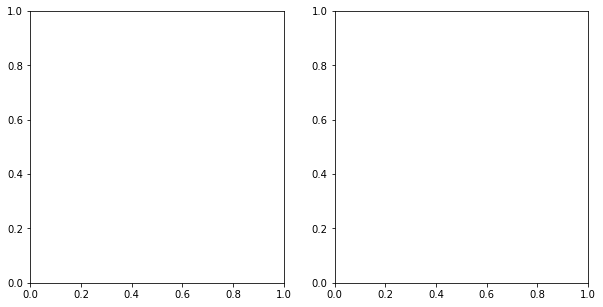

In [24]:
fig, (ax1, ax2)  = plt.subplots(1,2, figsize=(10,5))

ep.plot_rgb(mosaic,
            rgb=[0, 1, 2],
            stretch=True,
            ax=ax2,
            title="Landsat8 Aerial, 2020-04-26")


ax2.set_axis_off()

plt.show()

In [ ]:
# Create output dir to hold cropped files
landsat_crop_dir = os.path.join(
    "landsat", "LC08_L1TP_045031_20200426_20200426_01_RT", "cropped")



# Reproject aoi and siskiyou gdf into CRS of landsat scene
with rio.open(rgb_paths[0]) as src:
    aoi_reproj = aoi.to_crs(src.crs)
    siskiyou_reproj = siskiyou.to_crs(src.crs)

# Crop rasters in R, G, B list
es.crop_all(raster_paths=rgb_paths,
            output_dir=landsat_crop_dir,
            geoms=aoi_reproj,
            overwrite=True)

# Fetch cropped bands
landsat_cropped_bands = sorted(glob(os.path.join(landsat_crop_dir, "*B?_crop.tif")))

# Stack bands
landsat_stacked, landsat_stacked_meta = es.stack(landsat_cropped_bands, nodata=-9999)

# Get plotting extent
landsat_extent = plotting_extent(landsat_stacked[0], landsat_stacked_meta['transform'])

In [ ]:
def crop_stack_data(files_to_crop, crop_dir_path, crop_bound):
    """
    Takes a list of image filepaths to crop and boundaries 
    of an area of interest and returns a cropped and stacked array
    of bands from the original raster.

    Parameters
    ----------
    files_to_crop: list of filepaths (strings)
        List of filepaths to the image files to crop and stack.
        List order determines order of stacked raster that is returned.

    crop_dir_path: filepath (string)
        Path to directory that will store cropped image files. If this directory
        does not exist, this function will create it.

    crop_bound: Geopandas geodataframe
        Geodataframe with 1 item: clip boundaries. Function will attempt to
        project this to the same CRS as the image files from files_to_crop.

    Returns
    -------
    stacked_raster: stacked masked numpy array
        Stacked, cropped and clipped numpy masked array

    stacked_raster_meta: Rasterio profile 
        Dictionary-like object containing post-crop dtype, 
        nodata values, crs, etc. Used for reprojecting 
        and determining extents for plotting.

    """

    # Create new directory to store files if it does not exist
    if not os.path.exists(crop_dir_path):
        print("Output folder does not exist, creating...", end="")
        os.makedirs(crop_dir_path)
        print(" Done.")

    with rio.open(files_to_crop[0]) as src:
        crop_bound_reproj = crop_bound.to_crs(src.crs)

    # Crop all rasters in files_to_crop list
    es.crop_all(raster_paths=files_to_crop,
                output_dir=crop_dir_path,
                geoms=crop_bound_reproj,
                overwrite=True)

    # Fetch the cropped rasters by their extension and sort them
    all_bands = sorted(glob(os.path.join(crop_dir_path, "*B[1-5]_crop.tif")))

    # Return a stacked raster
    stacked_raster, stacked_raster_meta = es.stack(all_bands, nodata=-9999)
    
    return stacked_raster, stacked_raster_meta